In [1]:
""" Union of hydrobasingadm36L01 and Whymap using geopandas parallel processing.
-------------------------------------------------------------------------------

TODO tomorrow: Simplify geometry of large input data, or snap geometries before
performing the union.

Avoid topology errors.


Step 1:
Create polygons (10x10 degree, 648).

Step 2:
Clip all geodataframes with polygons (intersect).

Step 3:
Peform union per polygon.

Step 4: 
Merge results into large geodataframe.

Step 5:
Dissolve on unique identifier.

Step 6:
Save output

Author: Rutger Hofste
Date: 20181203
Kernel: python35+
Docker: rutgerhofste/gisdocker:ubuntu16.04

"""

TESTING = 0
SCRIPT_NAME = "Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01"
OUTPUT_VERSION = 1

TOLERANCE = 0.000001 # degrees

RDS_DATABASE_ENDPOINT = "aqueduct30v05.cgpnumwmfcqc.eu-central-1.rds.amazonaws.com"
RDS_DATABASE_NAME = "database01"
RDS_INPUT_TABLE_RIGHT = "y2018m11d14_rh_whymap_to_rds_v01_v01"

S3_INPUT_PATH = "s3://wri-projects/Aqueduct30/processData/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01/output_V06/"
INPUT_FILE_NAME = "Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.pkl"

ec2_input_path = "/volumes/data/{}/input_V{:02.0f}".format(SCRIPT_NAME,OUTPUT_VERSION)
ec2_output_path = "/volumes/data/{}/output_V{:02.0f}".format(SCRIPT_NAME,OUTPUT_VERSION)
ec2_output_path_df = "/volumes/data/{}/outputdf_V{:02.0f}".format(SCRIPT_NAME,OUTPUT_VERSION)

s3_output_path = "s3://wri-projects/Aqueduct30/processData/{}/output_V{:02.0f}/".format(SCRIPT_NAME,OUTPUT_VERSION)
s3_output_path_df = "s3://wri-projects/Aqueduct30/processData/{}/outputdf_V{:02.0f}/".format(SCRIPT_NAME,OUTPUT_VERSION)


print("\nec2_output_path:", ec2_output_path,
      "\ns3_output_path: ", s3_output_path,
      "\ns3_output_path: ", s3_output_path,
      "\nS3_INPUT_PATH: ", S3_INPUT_PATH,
      "\nRDS_INPUT_TABLE_RIGHT: ",RDS_INPUT_TABLE_RIGHT)




ec2_output_path: /volumes/data/Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01/output_V01 
s3_output_path:  s3://wri-projects/Aqueduct30/processData/Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01/output_V01/ 
s3_output_path:  s3://wri-projects/Aqueduct30/processData/Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01/output_V01/ 
S3_INPUT_PATH:  s3://wri-projects/Aqueduct30/processData/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01/output_V06/ 
RDS_INPUT_TABLE_RIGHT:  y2018m11d14_rh_whymap_to_rds_v01_v01


In [2]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
sys.version

Y2018M12D04 UTC 11:15


'3.5.4 |Anaconda, Inc.| (default, Nov 20 2017, 18:44:38) \n[GCC 7.2.0]'

In [3]:
import os
import sqlalchemy
import multiprocessing
import numpy as np
import pandas as pd
import geopandas as gpd
from google.cloud import bigquery
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import snap

In [4]:
#r {ec2_output_path}
#!rm -r {ec2_output_path}
!mkdir -p {ec2_input_path}
!mkdir -p {ec2_output_path}
!mkdir -p {ec2_output_path_df}

In [5]:
!aws s3 cp {S3_INPUT_PATH} {ec2_input_path} --recursive

download: s3://wri-projects/Aqueduct30/processData/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01/output_V06/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.cpg to ../../../../data/Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01/input_V01/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01/output_V06/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.prj to ../../../../data/Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01/input_V01/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.prj
download: s3://wri-projects/Aqueduct30/processData/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01/output_V06/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.shx to ../../../../data/Y2018M12D03_RH_Hybas6GADM36L01_U_Whymap_PP_V01/input_V01/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V01.shx
download: s3://wri-projects/Aqueduct30/processData/Y2018M11D29_RH_Hybas6_U_GADM36L01_GPD_PP_Merge_V0

In [6]:
cpu_count = multiprocessing.cpu_count()
cpu_count = cpu_count -2 #Avoid freeze
print("Power to the maxxx:", cpu_count)

Power to the maxxx: 14


In [7]:
F = open("/.password","r")
password = F.read().splitlines()[0]
F.close()

engine = sqlalchemy.create_engine("postgresql://rutgerhofste:{}@{}:5432/{}".format(password,RDS_DATABASE_ENDPOINT,RDS_DATABASE_NAME))

In [8]:
cell_size = 10

In [9]:
def create_fishnet_gdf(cell_size):
    crs = {'init': 'epsg:4326'}
    lats = np.arange(-90,90,cell_size)
    lons = np.arange(-180,180,cell_size)
    geoms = []
    for lat in lats:
        for lon in lons:
            llcr = (lon,lat)
            lrcr = (lon+cell_size, lat)
            urcr = (lon+cell_size, lat+cell_size)
            ulcr = (lon, lat+ cell_size)
            geom = Polygon([llcr,lrcr,urcr,ulcr])
            geoms.append(geom)
    gs = gpd.GeoSeries(geoms)
    gdf_grid = gpd.GeoDataFrame(geometry=gs)
    gdf_grid.crs = crs
    return gdf_grid

def post_process_geometry(geometry):
    """ Post Process Shapely Geometries after Intersection
    
    Shapely does not always create the desired output geometry. When
    vertices overlap, the result can be a geometryCollection with
    (mutli)polygons and LineStrings or Points. 
    
    This function converts the results of an intersection. It will
    remove empty geometries
    
    Args: 
        SIMPLIFY_TOLERANCE(double): Global parameter to specify 
            simplification tolerance.
        geomerty (shapely object): GeometryCollection, Multipolygon
            Polygon, Linestring etc.
            
    Returns:
        geometry_out(shapely object): MultiPolygon or
            Polygon of simplified geometry.
            
    Usage:
        apply to geodataframe geometry column.
    
    """
    geometry_buffered = geometry.buffer(0)
    return geometry_buffered


def clip_gdf(gdf_in,polygon):
    """
    Clip geodataframe using shapely polygon.
    Make sure crs is compatible.
    
    Removes any geometry that is (multi)polygon. i.e. LineStrings and Points are Removed
    
    Args:
        gdf (GeoDataFrame): GeoDataFrame in.
        polygon (Shapely Polygon): Polygon used for clipping
    
    """
    crs = gdf_in.crs
    gdf_intersects = gdf_in.loc[gdf_in.geometry.intersects(polygon)]
    df_intersects = gdf_intersects.drop(columns=[gdf_intersects.geometry.name])
    gs_intersections = gpd.GeoSeries(gdf_intersects.geometry.intersection(polygon),crs=crs)
    gdf_clipped = gpd.GeoDataFrame(df_intersects,geometry=gs_intersections)  
    
    # Some clipping results in GeometryCollections with polygons and LineStrings or Points. Convert valid geometry to Multipolygon
    gdf_clipped.geometry = gdf_clipped.geometry.apply(post_process_geometry)
    gdf_clipped_valid = gdf_clipped.loc[gdf_clipped.geometry.is_empty == False]
    return gdf_clipped_valid


def create_union_gdfs(gdf):
    index = gdf.index[0]
    print("Processing: ", index)
    df_out = pd.DataFrame()
    start = datetime.datetime.now()
    polygon = gdf.iloc[0].geometry
    destination_path = "{}/gdf_union_{}.pkl".format(ec2_output_path,index)
    
    gdf_left_clipped= clip_gdf(gdf_left,polygon)
    gdf_right_clipped = clip_gdf(gdf_right,polygon)
    
    if gdf_left_clipped.shape[0] == 0 and gdf_right_clipped.shape[0] == 0:

        gdf_out = None
        write_output = False
    elif gdf_left_clipped.shape[0] != 0 and gdf_right_clipped.shape[0] == 0:
        gdf_out = gdf_left_clipped
        write_output = True
    elif gdf_left_clipped.shape[0] == 0 and gdf_right_clipped.shape[0] != 0:
        gdf_out = gdf_right_clipped
        write_output = True
    elif gdf_left_clipped.shape[0] != 0 and gdf_right_clipped.shape[0] != 0:        
        gdf_union = gpd.overlay(gdf_left_clipped,gdf_right_clipped,how="union")
        gdf_out = gdf_union
        write_output = True        
    
    
    if write_output:
        if TESTING:
            end = datetime.datetime.now()
            elapsed = end - start
            gdf_out["time_processed"] = elapsed.total_seconds()
            gdf_out["tile_index"] = index
        else:
            pass
        gdf_out.to_pickle(path=destination_path)
    else:
        pass
    
    print("Succesfully processed", index)
    return  gdf_out

In [10]:
gdf_grid = create_fishnet_gdf(cell_size)

In [11]:
gdf_grid.head()

,geometry
0,"POLYGON ((-180 -90, -170 -90, -170 -80, -180 -..."
1,"POLYGON ((-170 -90, -160 -90, -160 -80, -170 -..."
2,"POLYGON ((-160 -90, -150 -90, -150 -80, -160 -..."
3,"POLYGON ((-150 -90, -140 -90, -140 -80, -150 -..."
4,"POLYGON ((-140 -90, -130 -90, -130 -80, -140 -..."


In [12]:
gdf_grid.shape

(648, 1)

In [13]:
input_path = "{}/{}".format(ec2_input_path,INPUT_FILE_NAME)

In [14]:
gdf_left = pd.read_pickle(input_path)

In [15]:
gdf_left.head()

,geometry,gid_1,pfaf_id,tile_index,time_processed
0,(POLYGON ((109.1899119372771 -0.13726455130724...,IDN.12_1,521501.0,316,21.334714
1,"(POLYGON ((109.29682159 -1.730021, 109.2963867...",IDN.12_1,521399.0,316,21.334714
2,"(POLYGON ((109.8581099735913 0, 109.8583333333...",IDN.12_1,521502.0,316,21.334714
3,(POLYGON ((109.158231984216 -0.210504352512889...,IDN.12_1,521401.0,316,21.334714
4,POLYGON ((109.9451550043398 -1.123588117805635...,IDN.12_1,521397.0,316,21.334714


In [16]:
gdf_left.shape

(35751, 5)

In [21]:
sql = """
SELECT
  aqid,
  geom
FROM
  {}
""".format(RDS_INPUT_TABLE_RIGHT)

In [22]:
gdf_right = gpd.read_postgis(sql=sql,
                             con=engine)

In [23]:
gdf_right.head()

,aqid,geom
0,0,(POLYGON ((-27.61888898379225 81.4749958595083...
1,19,(POLYGON ((-16.91555506127432 81.8560967874564...
2,20,(POLYGON ((-27.61888898379225 81.4749958595083...
3,25,(POLYGON ((63.47083247656703 81.58249504685597...
4,34,(POLYGON ((-94.67110548100065 80.0569264559232...


In [24]:
gdf_right.shape

(3402, 2)

In [25]:
# got error index 265 (intersection)

In [26]:
gdf_grid_test = gdf_grid[265:266]

In [27]:
polygon = gdf_grid_test.iloc[0].geometry

In [28]:
gdf_clipped_left_test = clip_gdf(gdf_left,polygon)

In [29]:
gdf_clipped_right_test = clip_gdf(gdf_right,polygon)

In [30]:
%matplotlib inline

In [38]:
gdf_clipped_left_test_selection = gdf_clipped_left_test.loc[(gdf_clipped_left_test["gid_1"] == "BRA.5_1") & ((gdf_clipped_left_test["pfaf_id"] == 634708.000000000000000 )|(gdf_clipped_left_test["pfaf_id"] == 634508.000000000000000 )) ]

In [134]:
gdf_clipped_left_test2 = gdf_clipped_left_test[30:285]

In [135]:
gdf_union = gpd.overlay(gdf_clipped_left_test2,gdf_clipped_right_test,how="union")

In [110]:
test_left = gdf_clipped_left_test[30:31]

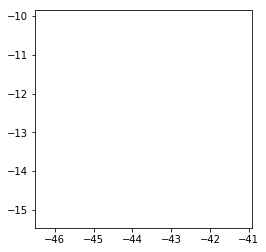

In [142]:
test_left.plot()

In [138]:
test_right = gdf_clipped_left_test[285:286]

In [139]:
test_right

,gid_1,pfaf_id,tile_index,time_processed,geometry
28276,BRA.13_1,635407.0,265,16.235137,POLYGON ((-42.45416666666664 -16.6333333333333...


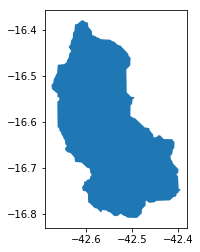

In [141]:
test_right.plot()

In [143]:
test_union = gpd.overlay(test_left,test_right,how="union")

In [ ]:
gdf_grid_list = np.array_split(gdf_grid, gdf_grid.shape[0])

In [ ]:
len(gdf_grid_list)

In [ ]:
gdf_grid_test = gdf_grid[265:266]

In [ ]:
p= multiprocessing.Pool(processes=cpu_count)
df_out_list = p.map(create_union_gdfs,gdf_grid_list)
p.close()
p.join()

In [ ]:
df_out = pd.concat(df_out_list, ignore_index=True)

In [ ]:
output_path_df = "{}/df_out.pkl".format(ec2_output_path_df)

In [ ]:
df_out.to_pickle(output_path_df)